In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr 
import datetime as dt 

import scipy 
from scipy import signal
import netCDF4

# for reading CDF file: 
import cdflib 

In [8]:
path = 'C:\\Users\\vboat\\OneDrive\\Documents\\SIO\\fall23\\SIO221\\sioc221a\\week7\\' # windows is stupid sometimes
file = 'class10_record_netcf.cdf'
fn = path+file

In [19]:
cdf = cdflib.CDF(fn)
cdf.cdf_info()


CDFInfo(CDF=WindowsPath('C:/Users/vboat/OneDrive/Documents/SIO/fall23/SIO221/sioc221a/week7/class10_record_netcf.cdf'), Version='3.7.0', Encoding=6, Majority='Column_major', rVariables=[], zVariables=['data', 'time'], Attributes=[], Copyright='\nCommon Data Format (CDF)\nhttps://cdf.gsfc.nasa.gov\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(User support: gsfc-cdf-support@lists.nasa.gov)\n', Checksum=False, Num_rdim=0, rDim_sizes=[], Compressed=False, LeapSecondUpdate=None)

In [30]:
data = cdf.varget('data')[0]
time = cdf.varget('time')[0]

print(cdf.varinq('time'))
print(cdf.varinq('data'))

# seems like no information about time variable, nor the data variable ....

VDRInfo(Variable='time', Num=1, Var_Type='zVariable', Data_Type=45, Data_Type_Description='CDF_DOUBLE', Num_Elements=1, Num_Dims=1, Dim_Sizes=[16000], Sparse='No_sparse', Last_Rec=0, Rec_Vary=True, Dim_Vary=[-1], Compress=0, Pad=array([-1.e+30]), Block_Factor=0)
VDRInfo(Variable='data', Num=0, Var_Type='zVariable', Data_Type=45, Data_Type_Description='CDF_DOUBLE', Num_Elements=1, Num_Dims=1, Dim_Sizes=[16000], Sparse='No_sparse', Last_Rec=0, Rec_Vary=True, Dim_Vary=[-1], Compress=0, Pad=array([-1.e+30]), Block_Factor=0)


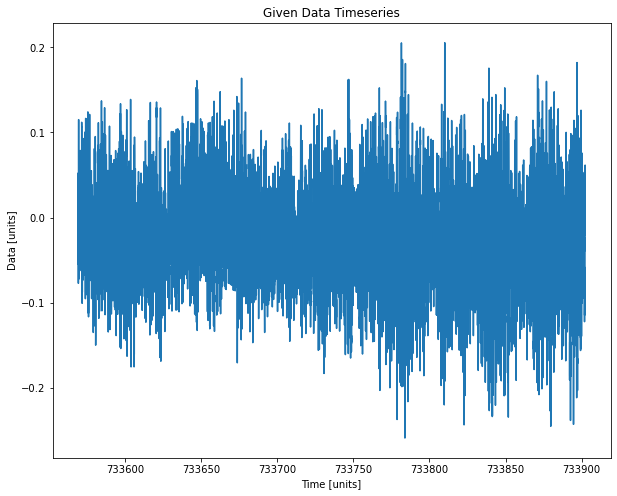

In [35]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(time,data)
ax.set(xlabel='Time [units]',ylabel='Data [units]', title='Given Data Timeseries')
plt.show()


In [36]:
len(data)

16000

In [40]:
# size of t_segments - arbitrary
tlen = int(len(data)/10)
# sampling frequency 
deltat = np.diff(time) 

step = np.nanmean(deltat) # step size (in days)
Nyq = 1/(2*step) # Nyquist frequency
period = step*N # this is the entire period (in days)
df = 1/period # fundamental frequency

In [93]:
deltat
segtime = time[tlen]-time[0]
print(segtime)


33.33333333337214


In [52]:
tsegs, dsegs = unknown_windowing(time,data,tseg=tlen)

In [51]:
# function for windowing  

def unknown_windowing(time,data,tseg=int): 
    # this function will return segmented arrays (of size [#segments,#N samples of data in each segment]) from a dataset with an associated time vector 
    # time: full time dataset (in datenumbers/integers )
    # data: full dataset of interest 
    # tsegs: the number of datapoints  desired in your segmenting [ in days ]
    # deltat: the sample spacing between your datapoints [in minutes]
    
    # returns: 
    # time_segs: segments with their original time stamps associated 
    # data_segs: segmented data as an array of [#segments,#N samples of data in each segment]

    import numpy as np 

    # number of tseg intervals encompassed in full dataset
    intervals = int(len(time)/tseg)
    # with 50% overlaps, it will be doubled but 1 less (because start 50% and end 50%)
    cycles = (intervals*2)-1

    num_samples = int(np.floor(len(time)/cycles)) # number of samples in each window 
    

    # can make arrays the correct size because we know how many 10 min samples will be in 60 days 
    # each array = (segment num, data within segment) 
    data_segs = np.zeros((cycles,num_samples))
    time_segs = np.zeros((cycles,num_samples))

    ind = 0
    jump = int(num_samples/2); 
    for nn in np.arange(0,cycles): 
        # looping through each segment in which we will save data 
        data_segs[nn,:] = data[ind:ind+num_samples]
        time_segs[nn,:] = time[ind:ind+num_samples]
        
        # now add to the ind (start index) and jump (number of samples in the segment = 8640)
        ind = ind + jump

    return time_segs,data_segs
    

In [99]:
# function for fft and spectra analysis 

def fft_analysis(data,time,demean=1,detrend=1,hanning=1,all_pars=0):
    # specifications for inputs: 
    # data_array should be size = (segments,data_in_segment); each data_in_segment column should be the same length
    # time array = should be the same size as data_array, could adapted for just a 1D vector. 
    # aka: you must window properly before using this function 
    # then, selecting whether to demean, detrend, hanning window, etc. 

    # returns: 
    # freqs: frequency array associated with spectrum/FFT
    # avg_fft: average fourier transform to plot (real & complex)
    # tot_amp: averaged spectrum 
    # err_low, err_high = high and low errors of dataset 

    import numpy as np 
    import matplotlib.pyplot as plt
    import xarray as xr 
    import datetime as dt 
    import scipy 
    from scipy import fft 
    from scipy import stats 
    
    
    # all segment lengths should be the same 
    N = len(data[0,:])  # == num_samples in each _window_
    deltat = np.diff(time)
    step = np.nanmean(deltat) # step size (in days)
    Nyq = 1/(2*step) # Nyquist frequency
    period = step*N # this is the entire segment period (in days)
    df = 1/period # fundamental frequency
    segs = len(data[:,0]) # total number of segment 
    M = segs
    
    # start workflow: analyze each segment individually 

    # fft & spectra of interest to be averaged 
    fft_oi = np.zeros((segs,N)) # real+complex FFT 
    amp_oi = np.zeros((segs,int(N/2))) # real spectra 
    
    # loop through segments
    for nn in np.arange(0,segs):
        segment = data[nn,:]
        segtime = time[nn,:]
    
        # demean & detrend 
    
        # calculate mean and linear trend 
        AA = np.array([np.ones(N), segtime]).T
        x = np.dot(np.linalg.inv(np.dot(AA.T, AA)), np.dot(AA.T, segment))
        mean = x[0]; trend = x[1]

        if demean==1: 
            segment = segment-mean # demean by calculated mean 
        
        if detrend==1: 
            segment = segment-trend*segtime # detrend from calculated trend
        
        if hanning==1: 
            # hanwin = np.cos(np.pi*segtime / period)**2 # calculate hanning window
            x = np.linspace(-0.5, 0.5, N) # Hanning domain
            hanwin = (np.cos(x*np.pi))**2 # Hanning values
            segment = segment*hanwin*np.sqrt(8/3) # normalize hanning window by sqrt(8/3)
            
        # compute each segment spectrum 
        # fourier transform
        fft = scipy.fft.fft(segment); 
        freq = scipy.fft.fftfreq(N,step); freq = scipy.fft.fftshift(freq); real_freq = freq[freq>=0]
        fftplot = scipy.fft.fftshift(fft)
        norm_fft = 1.0/N * np.abs(fftplot) # normalizing shifted FFT 
    
        r_idx = np.nonzero(freq>=0)
        amp = (norm_fft[r_idx])**2 # only selecting >0 to ignore complex (symmetric about x=0) - then square for amp

        # do the steps for the spectrum: 
        # normalization already done above
        amp = amp*2 # account for discarded redundant complex FFT coefficients 
        amp = amp/df # spectrum is normalized by fundamental freq
        
        fft_oi[nn,:] = norm_fft
        amp_oi[nn,:] = amp
    
        # inner loop parsevals (if desired)
        if all_pars == 1: 
            print(f"data variance & fft variance: {np.nanvar(segment):.04f} and {(np.sum(amp)*df):.04f}")

    avg_fft = np.nanmean(fft_oi,axis=0)
    tot_amp = np.nanmean(amp_oi,axis=0)
    
    # parseval's check : 
    print(f'Check Parsevals - data variance equals integral of spectrum?')
    print(f'Data variance / spectrum integration: {(np.nanvar(data) / (np.sum(tot_amp)*df) ): 0.4f} ')
    
    nu = 2*M # degrees of freedom 
    top = 1-0.05/2; bot = 0.05/2 
    err_low = nu/(scipy.stats.chi2.ppf(top, nu)); err_high = nu/(scipy.stats.chi2.ppf(bot, nu))
    
    return real_freq, avg_fft, tot_amp, err_low, err_high

In [66]:
# grant's function for spectra 

def spectrum(data, interval, detrend=True, Hanning=True):
    '''
    This function is used to make a spectrum given a time-series dataset and the time interval between samples
    in the dataset.

    Arguments:
        data (array) : A 1-d data array of which to have the spectrum computed
        interval (float) : Time interval between samples in data
        detrend (boolean) : Whether the data should be detrended before the spectrum is found
        Hanning (boolean) : Whether a Hanning window should be applied to the data before the spectrum is found

    Returns:
        spectrum (array) : A 1-d array containing the spectral values of the input data, in units (data units)
                            squared per frequency (cycles per time interval unit)
        f_range_pos (array) : A 1-d array containing the frequency values corresponding to each spectral value,
                            in units of cycles per time interval unit
    '''
    import scipy.signal as signal
    N = len(data)
    f_range = np.fft.fftfreq(N, d=interval) #creating an array of frequencies
    f_range_pos = f_range[(f_range > 0)] #creating an array of positive frequencies
    delta_f = 1/(N*interval) #finding the fundamental frequency

    
    x = np.linspace(-0.5, 0.5, N) # Hanning domain
    hanning = np.sqrt(8/3)*((np.cos(x*np.pi))**2) # Hanning values

    # various different ffts to be taken, depending on the detrend and Hanning conditions
    if detrend and Hanning:
        fft=np.fft.fft(hanning*signal.detrend(data)) #applying Hanning window and detrend
    elif detrend and Hanning == False:
        fft = np.fft.fft(signal.detrend(data)) #applying just detrend
    elif detrend == False and Hanning:
        fft = np.fft.fft(hanning*data) #applying just Hanning window
    else: 
        fft = np.fft.fft(data) #just FFTing raw data

    normal = np.abs(fft[(f_range > 0)])/N #normalize and only use positive freqs
    spectrum = 2*(normal**2)/delta_f #spectra formula and multiply by 2 to account for negative frequencies


    return spectrum, f_range_pos

In [68]:
deltat
specs = np.zeros((len(tsegs[:,0]),int(len(tsegs[0,:])/2)-1))
print(specs.shape)
print(tsegs.shape)


(19, 420)
(19, 842)


array([0.02083333, 0.02083333, 0.02083333, ..., 0.02083333, 0.02083333,
       0.02083333])

In [100]:
# windowing with unknown dataset: 

tsegs, dsegs = unknown_windowing(time,data,tseg=tlen)

# grant's funtion 

interval = np.nanmean(deltat); 
period = (time[-1]-time[0])
df = 1/period
df_window = 1/segtime
specs = np.zeros((len(tsegs[:,0]),int(len(tsegs[0,:])/2)-1))

for nn,dd in enumerate(dsegs): 
    [spec,f_range_pos] = spectrum(dd,interval)
    specs[nn,:] = spec
    #print(f'variance == integral of spectrum? {np.nanvar(dd)/  np.nansum(spec)*df} ? {specsum} ')


    
avg_spec = np.nanmean(specs,axis=0)
frequency = f_range_pos 

detrended = signal.detrend(data)
variance = np.nanvar(data)
# variance = np.nanmean(detrended**2)
specsum = np.nansum(avg_spec)*df_window
print(f'variance == integral of spectrum? {variance } ? {specsum} ')
    
# use victoria's function 

# finding spectra for multi-year spectra 
[f,fft,amp,erl,erh] = fft_analysis(dsegs,tsegs,demean=1,detrend=1,hanning=1,all_pars=1)




variance == integral of spectrum? 0.00394484853960935 ? 0.0014470478858308973 
data variance & fft variance: 0.0026 and 0.0026
data variance & fft variance: 0.0029 and 0.0030
data variance & fft variance: 0.0034 and 0.0034
data variance & fft variance: 0.0035 and 0.0035
data variance & fft variance: 0.0024 and 0.0024
data variance & fft variance: 0.0034 and 0.0034
data variance & fft variance: 0.0020 and 0.0020
data variance & fft variance: 0.0022 and 0.0022
data variance & fft variance: 0.0036 and 0.0036
data variance & fft variance: 0.0036 and 0.0036
data variance & fft variance: 0.0025 and 0.0025
data variance & fft variance: 0.0034 and 0.0034
data variance & fft variance: 0.0024 and 0.0024
data variance & fft variance: 0.0018 and 0.0018
data variance & fft variance: 0.0016 and 0.0016
data variance & fft variance: 0.0022 and 0.0022
data variance & fft variance: 0.0022 and 0.0022
data variance & fft variance: 0.0039 and 0.0039
data variance & fft variance: 0.0028 and 0.0028
Check Par

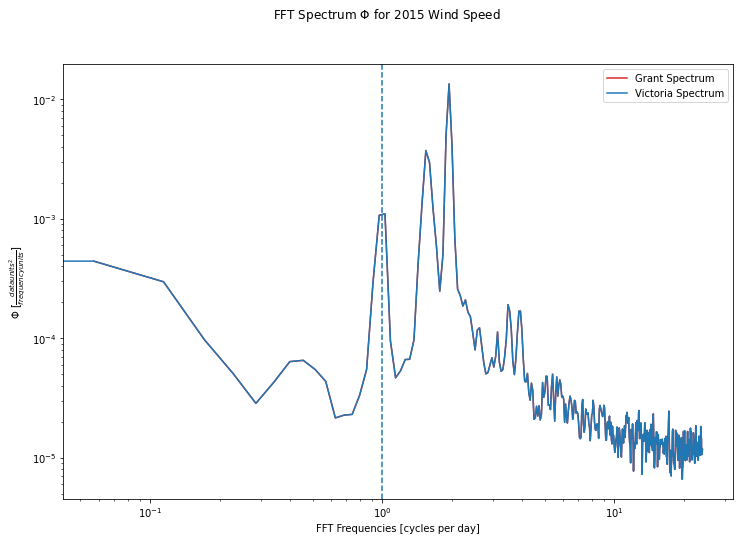

In [101]:
# plot comparing spectra 

fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.suptitle(r'FFT Spectrum $\Phi$ for 2015 Wind Speed')
ax.plot(frequency,avg_spec,label='Grant Spectrum',color='tab:red',zorder=1)

ax.plot(f,amp,label='Victoria Spectrum',color='tab:blue',zorder=2,linestyle='--')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set(ylabel=r'$\Phi$ [$ \frac{data units ^2}{ frequency units } $]',xlabel=r'FFT Frequencies [cycles per day]')
ax.axvline(x=1,linestyle='--')
#ax.set_ylim([10e-5, 10e1])
ax.legend(fontsize=10,loc='upper right')
plt.show()
